# **MODELOS DE PREDICCION PARA SERIES TEMPORALES DE DATOS DE CONTEO**
# <span style="color:Darkorange">PRECIPITACIONES EN MADRID (EL RETIRO)</span> 
# <span style="color:orange">Predicciones mensuales</span> 

Antonio Nogués Podadera

In [1]:
import datetime
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster

from datetime import timedelta
from hmmlearn.hmm import MultinomialHMM

import math
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from scipy.stats import binom
from patsy import dmatrices

import statsmodels.api as sm
from hmmlearn import hmm

from aux_functions import *

import warnings
warnings.filterwarnings('ignore')

Cargar dataframe de datos de precipitaciones en Madrid (El Retiro)

In [2]:
# Lectura de datos

df = pd.read_csv('../data/df_precipitaciones.csv', sep=';')

In [3]:
# Comprobar si la columna fecha es de tipo datetime

df['fecha'].dtype

dtype('O')

In [4]:
# Conversion a formato datetime de la columna fecha

df['fecha'] = pd.to_datetime(df['fecha'],format="%Y/%m/%d")

In [5]:
# Cambio de nombre de la columna de datos para estandarizar el proceso

df.rename(columns={'prec': 'data'}, inplace=True)

# Análisis Exploratorio de Datos (EDA)

### Análisis de valores nulos

El tratamiento de valores NaN supone un punto importante puesto que en el caso de existir algun valor nulo, este debería ser tratado de forma adecuada para no introducir sesgos en el modelo.

In [6]:
# Contar valores NaN por columna
nan_por_columna = df.isna().sum()

# Contar valores NaN en total
total_nan = df.isna().sum().sum()

# Mostrar los resultados
print("Valores NaN por columna:")
print(nan_por_columna)
print("\nTotal de valores NaN:", total_nan)

Valores NaN por columna:
fecha    0
data     0
dtype: int64

Total de valores NaN: 0


No se han encontrado valores NaN por lo que no es necesario realizar ningún tratamiento.

### Análisis de valores duplicados

In [7]:
# Save in 'df' the duplicated rows.

date_duplicated = df[df.duplicated()]

# Print the number of duplicated rows in 'df' 

print('Valores duplicados: ' + str(len(date_duplicated)))

Valores duplicados: 0


### Análisis de Outliers

El análisis de outliers se realiza para detectar valores atípicos. En este caso queremos detectar los valores atípicos de la variable `prec` que es la que queremos predecir.

In [8]:
outliers = detectar_outliers(df, 'data', umbral=1.5)
outliers

,fecha,data
57,2018-03-01,22


Se han detectado un valor atípico, aunque no se han eliminado puesto que se considera que son valores reales y no errores de medida.

### Análisis gráfico

Este punto recogerá un análisis gráfico de la variable `prec` para ver su comportamiento. Primero se realizará un análisis de la serie original de precipitaciones para ver su comportamiento.

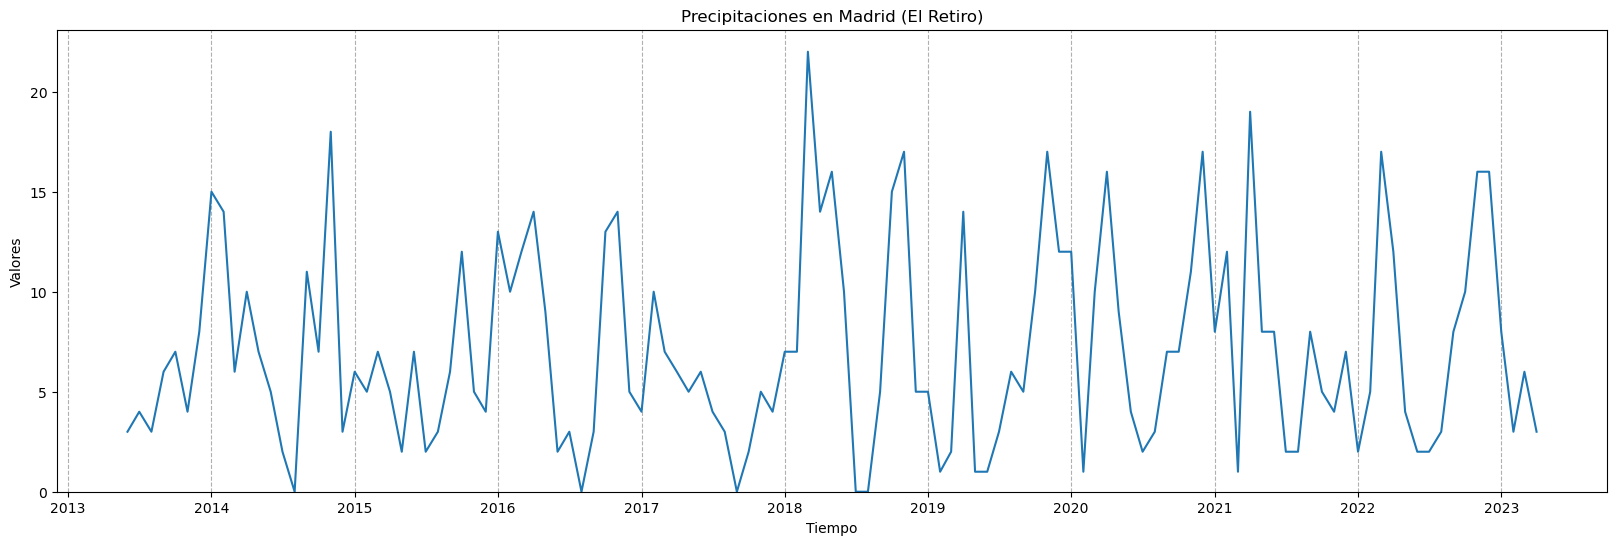

In [9]:
# Crear la figura y los ejes con un tamaño personalizado
fig, ax = plt.subplots(figsize=(20, 6))

# Graficar la serie temporal
ax.plot(df['fecha'], df['data'])

# Personalizar el gráfico
ax.set(xlabel='Tiempo', ylabel='Valores', title='Precipitaciones en Madrid (El Retiro)')
ax.grid(axis='x', linestyle='--')

# Establecer el límite inferior del eje y en 0
ax.set_ylim(bottom=0)

# Mostrar el gráfico
plt.show()

La serie presenta periodos estacionales muy marcados. En los meses de verano apenas hay precipitaciones y en los meses de otoño e invierno se concentran la mayor parte de las precipitaciones. Donde se produjeron más días con precipitaciones fue en el mes de marzo - abril del año 2018, donde hubo 20 días con precipitaciones (casi todo el mes).

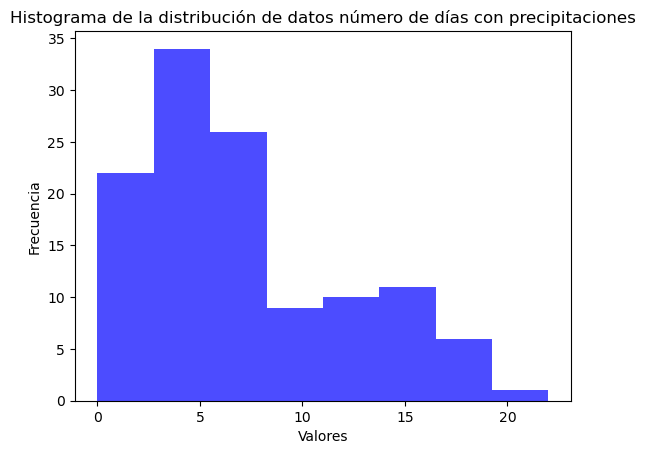

In [10]:
# Obtener los valores de la columna "data"
valores = df['data']

# Crear el histograma
plt.hist(valores, bins='auto', color='blue', alpha=0.7)

# Agregar etiquetas y título
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de la distribución de datos número de días con precipitaciones')

# Mostrar el histograma
plt.show()

# PREDICCIONES

Primero se calcularán las predicciones con modelos para datos de conteo y posteriormente se realizarán las predicciones con modelos que no son para datos de conteo como puede ser ARIMA, ETS y Naive para comparar los resultados.

In [11]:
# Semilla para todo el notebook

random_state = 1234567

## Modelos de datos de conteo

### Modelo oculto de Markov

In [12]:
# Copia del dataframe original para no transformarlo directamente

df_markov = df.copy()

In [13]:
# Establecer el índice del dataframe (columna fecha)

df_markov = df_markov.set_index('fecha')

In [14]:
# Separar en train y test

y_train, y_test = temporal_train_test_split(y=df_markov['data'].astype('float64').to_period('M'), test_size=6)

In [15]:
# Obtener las secuencias de observaciones (datos) de entrenamiento y prueba
observaciones_train = y_train.values.astype(float)
observaciones_test = y_test.values.astype(float)

# Crear y entrenar el modelo HMM con una distribución de Poisson
modelo_hmm = hmm.PoissonHMM(n_components=4, random_state=random_state) 

modelo_hmm.fit(observaciones_train.reshape(-1, 1))

# Realizar las predicciones para el conjunto de prueba
# Con el método predict se obtienen las predicciones de los estados ocultos y con sample se obtienen las predicciones de las observaciones

predicciones_markov, _ = modelo_hmm.sample(n_samples=6, random_state=random_state)


In [16]:
# Calcular Performance

performance_oculto_markov = ForecastPerformance(y_test, predicciones_markov)
performance_oculto_markov

,RMSE,MAPE
0,11.42,175.0


**Validación cruzada**

In [17]:
# Variables para almacenar las métricas de cada iteración
results = []

window_size = 20  # Tamaño inicial de la ventana de entrenamiento

# Longitud total del dataframe
total_length = df_markov.shape[0]

for i in range(window_size, total_length):
    # Dividir el conjunto de datos en train y test
    y_train = df_markov['data'].astype('float64').to_period('M').iloc[:i]
    y_test = df_markov['data'].astype('float64').to_period('M').iloc[i:i+1]  # Un solo paso adelante

    # Obtener las secuencias de observaciones (datos) de entrenamiento
    observaciones_train = y_train.values.astype(float)
    
    # Crear y entrenar el modelo HMM con una distribución de Poisson
    modelo_hmm = hmm.PoissonHMM(n_components=4)
    modelo_hmm.fit(observaciones_train.reshape(-1, 1))

    # Realizar las predicciones para el conjunto de prueba  
    # Con el método sample se obtienen las predicciones de los estados ocultos
    predicciones_markov_cv, _ = modelo_hmm.sample(n_samples=1, random_state=random_state)

    # Calcular y almacenar las métricas
    results.append(ForecastPerformance(y_test, predicciones_markov_cv))

# Concatenar todas las métricas y calcular la media
df_results = pd.concat(results)
average_metrics = df_results.mean()

# Crear un nuevo DataFrame con las métricas promedio
performance_oculto_markov_cv = pd.DataFrame({'MAPE': average_metrics['MAPE'], 'RMSE': average_metrics['RMSE']}, index=[0])

performance_oculto_markov_cv

,MAPE,RMSE
0,92.884848,7.010101


In [18]:
# Convertir las predicciones a una serie

predicciones_markov_serie = pd.Series(predicciones_markov.flatten(),
                  index=pd.date_range(start='2022-11', periods=predicciones_markov.shape[0], freq='M').strftime('%Y-%m'),
                  name='data')

predicciones_markov_serie = predicciones_markov_serie.astype(float)

# Convertir el índice en un PeriodIndex

predicciones_markov_serie.index = pd.to_datetime(predicciones_markov_serie.index).to_period('M')

In [19]:
# Separar en train y test para graficar correctamente, puesto que el y_test que prevalece ahora es el de la validación cruzada

y_train, y_test = temporal_train_test_split(y=df_markov['data'].astype('float64').to_period('M'), test_size=6)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='data'>)

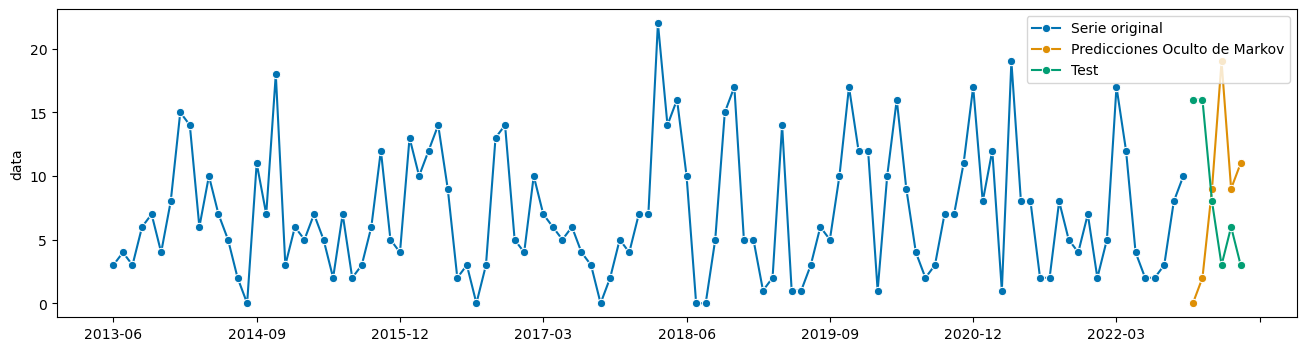

In [20]:
# Representacion grafica

plot_series(y_train["2013":], predicciones_markov_serie, y_test, labels=["Serie original", "Predicciones Oculto de Markov", "Test"])

### Modelo INAR(1)

In [21]:
# Copia del dataframe original para no transformarlo directamente

df_inarma = df.copy()

In [22]:
# Separar df_inarma en train y test

test_size = 6  # Tamaño del conjunto de prueba en meses

# Obtener la fecha de corte para separar train y test
cutoff_date = df["fecha"].iloc[-test_size]

# Dividir el DataFrame en train y test
df_inarma_train = df_inarma[df_inarma["fecha"] < cutoff_date]
df_inarma_test = df_inarma[df_inarma["fecha"] >= cutoff_date]

y_train, X_train = dmatrices('data ~ 1', df_inarma_train, return_type='dataframe')
y_test, X_test = dmatrices('data ~ 1', df_inarma_test, return_type='dataframe')

In [23]:
# Funciones y construcción del modelo INAR(1)

class PoissonINAR(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(PoissonINAR, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        #Fetch the parameters gamma and beta that we would be optimizing
        gamma = params[-1]
        beta = params[:-1]
        #Set y and X
        y = self.endog
        y = np.array(y)
        X = self.exog
        #Compute rho as a function of gamma
        rho = 1.0/(1.0+math.exp(-gamma))
        #Compute the Poisson mean mu as the exponentiated dot product of X and Beta
        mu = np.exp(X.dot(beta))
        #Init the list of loglikelihhod values, one value for each y
        ll = []
        #Compute all the log-likelihood values for the Poisson INAR(1) model
        for t in range(len(y)-1,0,-1):
            prob_y_t = 0
            for j in range(int(min(y[t], y[t-1])+1)):
                prob_y_t += poisson.pmf((y[t]-j), mu[t]) * binom.pmf(j, y[t-1], rho)
            ll.append(math.log(prob_y_t))
        ll = np.array(ll)
        #print('gamma='+str(gamma) + ' rho='+str(rho) + ' beta='+str(beta) + ' ll='+str(((-ll).sum(0))))
        #return the negated array of  log-likelihood values
        return -ll

    def fit(self, start_params=None, maxiter=1000, maxfun=5000, random_state=None,**kwds):
        #Add the gamma parameter to the list of exogneous variables that
        # the model will optimize
        self.exog_names.append('gamma')
        if start_params == None:
            #Start with some initial values of Beta and gamma
            start_params = np.append(np.ones(self.exog.shape[1]), 1.0)
        #Call super.fit() to start the training
        return super(PoissonINAR, self).fit(start_params=start_params,
            maxiter=maxiter, maxfun=maxfun, random_state=random_state,**kwds)

    def predict(self, params, exog=None, *args, **kwargs):
        #Fetch the optimized values of parameters gamma and beta
        fitted_gamma = params[-1]
        fitted_beta = params[:-1]
        X = np.array(exog)
        #Compute rho as a function of gamma
        rho = 1.0/(1.0+math.exp(-fitted_gamma))
        #Fetch the Intercept and the regression variables,
        # except for the last column which contains the lagged y values
        X = exog[:,:-1]
        #Fetch the lagged y values
        y_lag_1 = exog[:,-1]
        #Compute the predicted y using the Poisson INAR(1) model's equation
        y_pred = rho * y_lag_1 + np.exp(X.dot(fitted_beta))
        return y_pred

In [24]:
# Crear el modelo de Poisson INAR(1) y entrenarlo

inar_model = PoissonINAR(y_train, X_train)
inar_model_results = inar_model.fit(random_state=random_state)

print(inar_model_results.summary())

Optimization terminated successfully.
         Current function value: 3.410933
         Iterations: 44
         Function evaluations: 84
                             PoissonINAR Results                              
Dep. Variable:                   data   Log-Likelihood:                -385.44
Model:                    PoissonINAR   AIC:                             772.9
Method:            Maximum Likelihood   BIC:                             775.6
Date:                Fri, 09 Jun 2023                                         
Time:                        10:26:15                                         
No. Observations:                 113                                         
Df Residuals:                     112                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [25]:
# Preparar la matrix X para el cálculo de predicciones

X_test['y_lag_1'] = y_test.shift(1)
X_test = X_test.fillna(0)

# Cálculo de predicciones
inar_predictions = np.round(inar_model_results.predict(exog=X_test))

print(inar_predictions)

113    6.0
114    9.0
115    9.0
116    7.0
117    6.0
118    7.0
dtype: float64


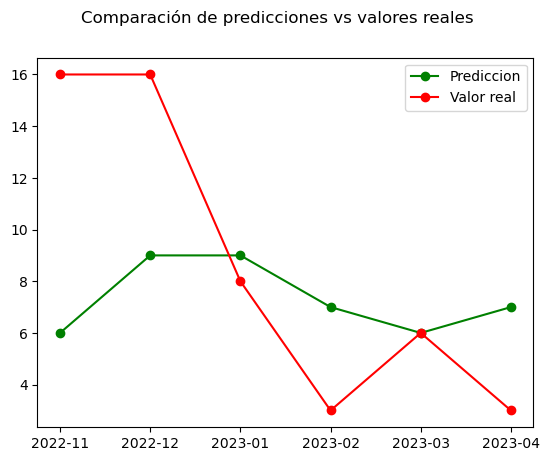

In [26]:
# Representación gráfica de las predicciones 

X_test.index = pd.date_range(start='2022-11', periods=len(X_test), freq='M').strftime('%Y-%m')

actual_counts = y_test['data']

fig = plt.figure()

fig.suptitle('Comparación de predicciones vs valores reales')
predicted, = plt.plot(X_test.index, inar_predictions, 'go-', label='Prediccion')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Valor real')

plt.legend(handles=[predicted, actual])

plt.show()

In [27]:
# Calcular Performance

performance_inar = ForecastPerformance(y_test, inar_predictions)
performance_inar

,RMSE,MAPE
0,5.51,64.24


**Validacion cruzada INAR(1)**

In [28]:
# Variables para almacenar las métricas de cada iteración
results_inar_1 = []

window_size = 20  # Tamaño inicial de la ventana de entrenamiento

# Longitud total del dataframe
total_length = df_inarma.shape[0]

for i in range(window_size, total_length):
    # Dividir el conjunto de datos en train y test
    df_train = df_inarma.iloc[:i]
    df_test = df_inarma.iloc[i:i+1]  

    # Preparar datos para el modelado
    y_train, X_train = dmatrices('data ~ 1', df_train, return_type='dataframe')
    y_test, X_test = dmatrices('data ~ 1', df_test, return_type='dataframe')

    # Crear y entrenar el modelo
    inar_model_cv_1 = PoissonINAR(y_train, X_train)
    inar_model_cv_results = inar_model_cv_1.fit(random_state=random_state)

    # Preparar la matriz X para el cálculo de predicciones
    X_test['y_lag_1'] = y_test.shift(1)
    X_test = X_test.fillna(0)

    # Cálculo de predicciones
    inar_predictions_cv_1 = np.round(inar_model_cv_results.predict(exog=X_test))

    # Calcular y almacenar las métricas
    results_inar_1.append(ForecastPerformance(y_test, inar_predictions_cv_1))

# Concatenar todas las métricas y calcular la media
df_results = pd.concat(results_inar_1)
average_metrics = df_results.mean()

# Crear un nuevo DataFrame con las métricas promedio
performance_inar_cv_1 = pd.DataFrame({'MAPE': average_metrics['MAPE'], 'RMSE': average_metrics['RMSE']}, index=[0])

performance_inar_cv_1

Optimization terminated successfully.
         Current function value: 3.069413
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 3.021347
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 2.970448
         Iterations: 48
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 2.930914
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 2.957696
         Iterations: 42
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 2.917139
         Iterations: 46
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 2.943359
         Iterations: 47
         Function evaluations: 90
Optimization terminated successful

,MAPE,RMSE
0,1.000800e+17,4.151515


### Modelo INAR(12)

In [29]:
# Copia del dataframe original para no transformarlo directamente

df_inar_12 = df.copy()

In [30]:
# Separar df_inarma en train y test

test_size = 6  # Tamaño del conjunto de prueba en meses

# Obtener la fecha de corte para separar train y test
cutoff_date = df["fecha"].iloc[-test_size]

# Dividir el DataFrame en train y test
df_inarma_train = df_inarma[df_inarma["fecha"] < cutoff_date]
df_inarma_test = df_inarma[df_inarma["fecha"] >= cutoff_date]

y_train, X_train = dmatrices('data ~ 1', df_inarma_train, return_type='dataframe')
y_test, X_test = dmatrices('data ~ 1', df_inarma_test, return_type='dataframe')

In [31]:
# Funciones y construcción del modelo INAR(12)

class PoissonINAR(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(PoissonINAR, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        #Fetch the parameters gamma and beta that we would be optimizing
        gamma = params[-1]
        beta = params[:-1]
        #Set y and X
        y = self.endog
        y = np.array(y)
        X = self.exog
        #Compute rho as a function of gamma
        rho = 1.0/(1.0+math.exp(-gamma))
        #Compute the Poisson mean mu as the exponentiated dot product of X and Beta
        mu = np.exp(X.dot(beta))
        #Init the list of loglikelihhod values, one value for each y
        ll = []
        #Compute all the log-likelihood values for the Poisson INAR(12) model
        for t in range(len(y)-1,0,-1):
            prob_y_t = 0
            for j in range(int(min(y[t], y[t-12])+1)):
                prob_y_t += poisson.pmf((y[t-12]-j), mu[t-12]) * binom.pmf(j, y[t-12], rho)
            ll.append(math.log(prob_y_t))
        ll = np.array(ll)
        #print('gamma='+str(gamma) + ' rho='+str(rho) + ' beta='+str(beta) + ' ll='+str(((-ll).sum(0))))
        #return the negated array of  log-likelihood values
        return -ll

    def fit(self, start_params=None, maxiter=1000, maxfun=5000, random_state=None,**kwds):
        #Add the gamma parameter to the list of exogneous variables that
        # the model will optimize
        self.exog_names.append('gamma')
        if start_params == None:
            #Start with some initial values of Beta and gamma
            start_params = np.append(np.ones(self.exog.shape[1]), 1.0)
        #Call super.fit() to start the training
        return super(PoissonINAR, self).fit(start_params=start_params,
            maxiter=maxiter, maxfun=maxfun, random_state=random_state,**kwds)

    def predict(self, params, exog=None, *args, **kwargs):
        #Fetch the optimized values of parameters gamma and beta
        fitted_gamma = params[-1]
        fitted_beta = params[:-1]
        X = np.array(exog)
        #Compute rho as a function of gamma
        rho = 1.0/(1.0+math.exp(-fitted_gamma))
        #Fetch the Intercept and the regression variables,
        # except for the last column which contains the lagged y values
        X = exog[:,:-1]
        #Fetch the lagged y values
        y_lag_12 = exog[:,-1]
        #Compute the predicted y using the Poisson INAR(12) model's equation
        y_pred = rho * y_lag_12 + np.exp(X.dot(fitted_beta))
        return y_pred

In [32]:
# Crear el modelo de Poisson INAR(12) y entrenarlo

inar12_model = PoissonINAR(y_train, X_train)
inar12_model_results = inar12_model.fit(random_state=random_state)

print(inar12_model_results.summary())

Optimization terminated successfully.
         Current function value: 3.117934
         Iterations: 43
         Function evaluations: 82
                             PoissonINAR Results                              
Dep. Variable:                   data   Log-Likelihood:                -352.33
Model:                    PoissonINAR   AIC:                             706.7
Method:            Maximum Likelihood   BIC:                             709.4
Date:                Fri, 09 Jun 2023                                         
Time:                        10:33:09                                         
No. Observations:                 113                                         
Df Residuals:                     112                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [33]:
# Preparar la matrix X para el cálculo de predicciones

X_test['y_lag_12'] = y_test.shift(1)
X_test = X_test.fillna(0)

# Cálculo de predicciones
inar12_predictions = np.round(inar12_model_results.predict(exog=X_test))

print(inar12_predictions)

113    5.0
114    9.0
115    9.0
116    7.0
117    6.0
118    7.0
dtype: float64


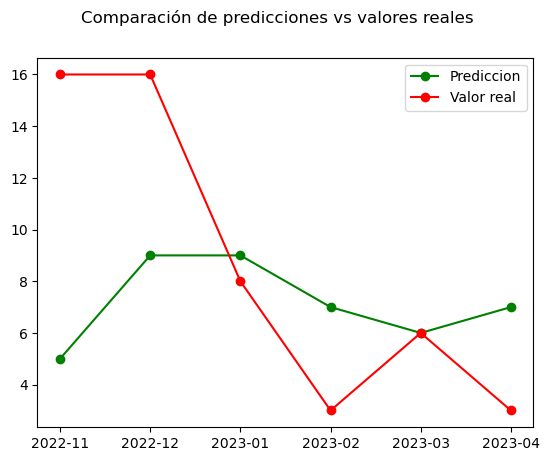

In [34]:
# Representación gráfica de las predicciones vs valores reales

X_test.index = pd.date_range(start='2022-11', periods=len(X_test), freq='M').strftime('%Y-%m')

actual_counts = y_test['data']

fig = plt.figure()

fig.suptitle('Comparación de predicciones vs valores reales')
predicted, = plt.plot(X_test.index, inar12_predictions, 'go-', label='Prediccion')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Valor real')

plt.legend(handles=[predicted, actual])

plt.show()

In [35]:
# Calcular Performance

performance_inar12 = ForecastPerformance(y_test, inar12_predictions)
performance_inar12

,RMSE,MAPE
0,5.82,65.28


**Validación Cruzada INAR(12)**

In [36]:
# Variables para almacenar las métricas de cada iteración
results = []

window_size = 20  # Tamaño inicial de la ventana de entrenamiento

# Longitud total del dataframe
total_length = df_inar_12.shape[0]

for i in range(window_size, total_length):
    # Dividir el conjunto de datos en train y test
    df_train = df_inar_12.iloc[:i]
    df_test = df_inar_12.iloc[i:i+1]  

    # Preparar datos para el modelado
    y_train, X_train = dmatrices('data ~ 1', df_train, return_type='dataframe')
    y_test, X_test = dmatrices('data ~ 1', df_test, return_type='dataframe')

    # Crear y entrenar el modelo
    inar_model_cv = PoissonINAR(y_train, X_train)
    inar_model_cv_results = inar_model_cv.fit(random_state=random_state)

    # Preparar la matriz X para el cálculo de predicciones
    X_test['y_lag_12'] = y_test.shift(1)
    X_test = X_test.fillna(0)

    # Cálculo de predicciones
    inar_predictions_cv_12 = np.round(inar_model_cv_results.predict(exog=X_test))

    # Calcular y almacenar las métricas
    results.append(ForecastPerformance(y_test, inar_predictions_cv_12))

# Concatenar todas las métricas y calcular la media
df_results = pd.concat(results)
average_metrics = df_results.mean()

# Crear un nuevo DataFrame con las métricas promedio
performance_inar_cv_12 = pd.DataFrame({'MAPE': average_metrics['MAPE'], 'RMSE': average_metrics['RMSE']}, index=[0])

performance_inar_cv_12

Optimization terminated successfully.
         Current function value: 2.584980
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 2.561426
         Iterations: 42
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 2.514512
         Iterations: 38
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 2.520006
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 2.685164
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 2.547157
         Iterations: 40
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 2.479389
         Iterations: 44
         Function evaluations: 85
Optimization terminated successful

,MAPE,RMSE
0,9.098181e+16,4.171717


## Modelos generales de predicción

### Naive

In [37]:
# Copia del df original

df_naive = df.copy()

In [38]:
# Establecer el índice del dataframe (columna fecha)

df_naive = df_naive.set_index('fecha')

In [39]:
# Separar los datos en train y test

y_train, y_test = temporal_train_test_split(y=df_naive['data'].astype('float64').to_period('M'), test_size=6)

In [40]:
# Se establece el horizonte temporal de las predicciones
fh_test = np.arange(1,7)

# Establecer la semilla aleatoria de NumPy
np.random.seed(random_state)

# Crear y ajustar el modelo Naive estacional
model_naive = NaiveForecaster(strategy='last') 

# Entrenar el modelo
model_naive.fit(y_train)

# Establecer la semilla aleatoria de NumPy nuevamente para la predicción
np.random.seed(random_state)

# Cálculo de predicciones
predicciones_naive = model_naive.predict(fh_test)

predicciones_naive

2022-11    10.0
2022-12    10.0
2023-01    10.0
2023-02    10.0
2023-03    10.0
2023-04    10.0
Freq: M, Name: data, dtype: float64

In [41]:
# Calcular Performance

performance_naive = ForecastPerformance(y_test, predicciones_naive)
performance_naive

,RMSE,MAPE
0,5.63,105.56


**Validacion cruzada**

In [72]:
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])

# Definir el CV
cv = ExpandingWindowSplitter(
    initial_window=20,
    step_length=1,
    fh=fh_test)

# Definir los modelos y los parámetros (GRID)
gscv = ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid=[{
        "forecaster": [NaiveForecaster()],
        "forecaster__strategy": ["drift", "last", "mean"],
    }],
    cv=cv,
    verbose=1,
    n_jobs=-1)

# Entrenar y ajustar los modelos
gscv.fit(y_train)

# Obtener el mejor estimador
best_estimator = gscv.best_forecaster_

# Predicción
naive_cv_pred = best_estimator.predict(fh=fh_test)

Fitting 88 folds for each of 3 candidates, totalling 264 fits


In [73]:
# Calcular Performance

performance_naive_cv = ForecastPerformance(y_test, naive_cv_pred)
performance_naive_cv

,RMSE,MAPE
0,5.71,68.31


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='data'>)

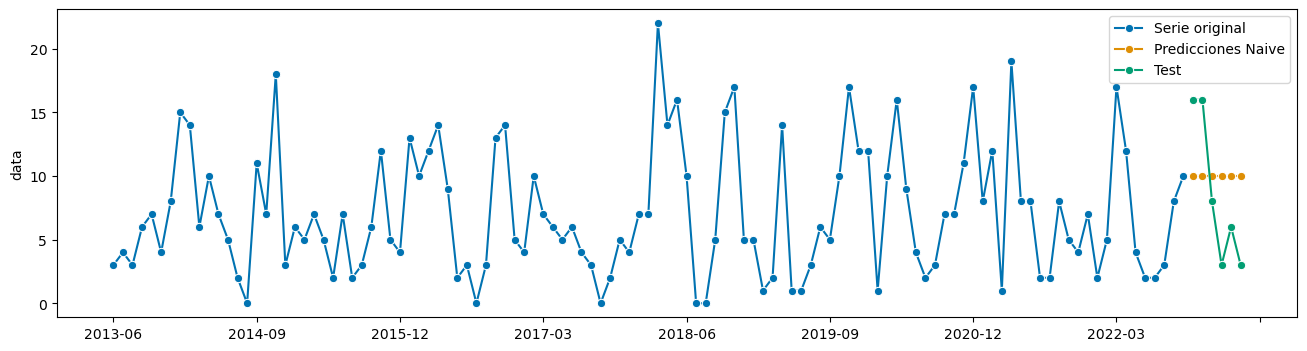

In [44]:
# Representacion grafica de predicciones Naive

plot_series(y_train["2013":], predicciones_naive, y_test, labels=["Serie original", "Predicciones Naive" , "Test"])

### ETS

In [45]:
# Copia del dataframe original

df_ets = df.copy()

In [46]:
# Establecer el índice del dataframe (columna fecha)

df_ets = df_ets.set_index('fecha')

In [70]:
# Separar los datos en train y test

y_train, y_test = temporal_train_test_split(y=df_ets['data'].astype('float64').to_period('M'), test_size=6)

In [68]:
# Se establece el horizonte temporal de las predicciones
fh_test = np.arange(1,7)

# Creación del modelo
data_model_ets = AutoETS(auto=True, sp=12, n_jobs=-1, random_state=random_state)

# Entrenamiento del modelo
data_model_ets.fit(y_train)

# Cálculo de predicciones
predicciones_ets = data_model_ets.predict(fh=fh_test)

In [71]:
# Calcular Performance

performance_ets_cv = ForecastPerformance(y_test, predicciones_ets)
performance_ets_cv

,RMSE,MAPE
0,6.06,98.77


**Validacion cruzada**

In [50]:
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", ExponentialSmoothing())])

# Definir el CV
cv = ExpandingWindowSplitter(
    initial_window=20,
    step_length=1,
    fh=fh_test)

# Definir los modelos y los parámetros (GRID)
gscv = ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid=[
    {
        "forecaster": [ExponentialSmoothing(sp=12)],
        "forecaster__trend": ["add", "mul"],
        "forecaster__damped_trend": [True, False],
        "forecaster__seasonal": ["add", "mul"],
    }],
    cv=cv,
    verbose=1,
    n_jobs=-1)

# Entrenar y ajustar los modelos
gscv.fit(y_train)

# Obtener el mejor estimador
best_estimator = gscv.best_forecaster_

# Predicción
ets_cv_pred_2 = best_estimator.predict(fh=fh_test)

Fitting 88 folds for each of 8 candidates, totalling 704 fits


In [51]:
# Calcular Performance

performance_ets_cv = ForecastPerformance(y_test, ets_cv_pred_2)
performance_ets_cv

,RMSE,MAPE
0,6.09,102.99


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='data'>)

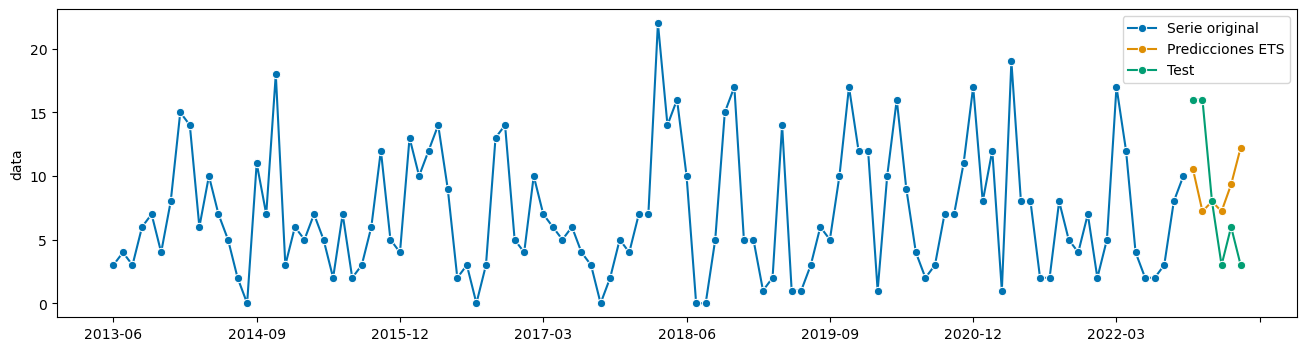

In [52]:
# Representacion grafica de predicciones ETS

plot_series(y_train["2013":], predicciones_ets, y_test, labels=["Serie original", "Predicciones ETS" , "Test"])

### ARIMA

In [53]:
# Copia del dataframe original

df_arima = df.copy()

In [54]:
# Establecer el índice del dataframe (columna fecha)

df_arima = df_arima.set_index('fecha')

In [55]:
# Separar los datos en train y test

y_train, y_test = temporal_train_test_split(y=df_arima['data'].astype('float64').to_period('M'), test_size=6)

In [56]:
# Se establece el horizonte temporal de las predicciones+

fh_test = np.arange(1,7)

# Creación del modelo
arima_model = AutoARIMA(sp=12,suppress_warnings=True, n_jobs=-1, random_state=random_state)

# Fit del modelo
arima_model.fit(y_train)

AutoARIMA(n_jobs=-1, random_state=1234567, sp=12, suppress_warnings=True)

In [57]:
# Predicción

prediccion_arima = arima_model.predict(fh=fh_test)

In [58]:
# Calcular Performance

performance_arima = ForecastPerformance(y_test, prediccion_arima)
performance_arima

,RMSE,MAPE
0,4.96,66.5


**Validacion cruzada**

In [59]:
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", AutoARIMA(sp=12))])

# Definir el CV
cv = ExpandingWindowSplitter(
    initial_window=20,
    step_length=1,
    fh=fh_test)

# Definir los modelos y los parámetros (GRID)
gscv = ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid=[
        {
            "forecaster__seasonal": [False, True],
            "forecaster__stepwise": [True, False],
        }
    ],
    cv=cv,
    verbose=1,
    n_jobs=-1)

# Entrenar y ajustar los modelos
gscv.fit(y_train)

# Obtener el mejor estimador
best_estimator = gscv.best_forecaster_

# Predicción
arima_cv_pred_2 = best_estimator.predict(fh=fh_test)

Fitting 88 folds for each of 4 candidates, totalling 352 fits


In [60]:
# Calcular Performance

performance_arima_cv = ForecastPerformance(y_test, arima_cv_pred_2)
performance_arima_cv

,RMSE,MAPE
0,5.6,98.82


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='data'>)

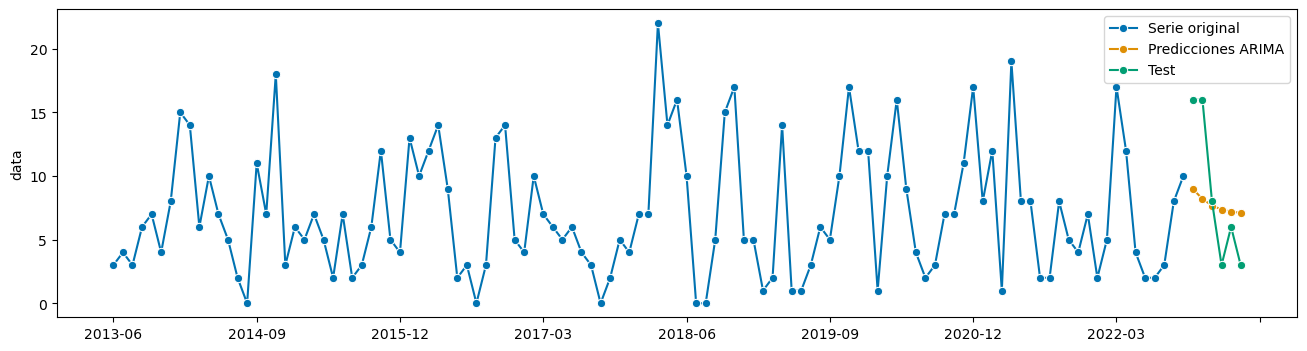

In [61]:
# Representacion grafica de predicciones ARIMA

plot_series(y_train["2013":], prediccion_arima, y_test, labels=["Serie original", "Predicciones ARIMA" , "Test"])

# COMPARACIÓN DE RESULTADOS

In [74]:
# Dataframe que recoge la performance de los modelos con validación cruzada

df_performance = pd.DataFrame({'Modelo': ['INAR(12)', 'INAR(1)', 'Oculto de Markov' ,'Naive', 'ETS','ARIMA'], 
                               
                                'RMSE': [np.squeeze(performance_inar_cv_12['RMSE'].values.round(2)),
                                         np.squeeze(performance_inar_cv_1['RMSE'].values.round(2)), 
                                         np.squeeze(performance_oculto_markov_cv['RMSE'].values.round(2)),
                                         np.squeeze(performance_naive_cv['RMSE'].values.round(2)),
                                         np.squeeze(performance_ets_cv['RMSE'].values.round(2)), 
                                         np.squeeze(performance_arima_cv['RMSE'].values.round(2))],

                                'MAPE': [np.squeeze(performance_inar_cv_12['MAPE'].values.round(2)),
                                         np.squeeze(performance_inar_cv_1['MAPE'].values.round(2)), 
                                         np.squeeze(performance_oculto_markov_cv['MAPE'].values.round(2)), 
                                         np.squeeze(performance_naive_cv['MAPE'].values.round(2)),
                                         np.squeeze(performance_ets_cv['MAPE'].values.round(2)),   
                                         np.squeeze(performance_arima_cv['MAPE'].values.round(2))]})

df_performance

,Modelo,RMSE,MAPE
0,INAR(12),4.17,9.098181065394949e+16
1,INAR(1),4.15,1.0007999171934443e+17
2,Oculto de Markov,7.01,92.88
3,Naive,5.71,68.31
4,ETS,6.06,98.77
5,ARIMA,5.6,98.82


In [63]:
date_index = pd.date_range(start='2022-11', periods=len(y_test), freq='M').strftime('%Y-%m')

predicciones_markov_serie.index = date_index[:len(predicciones_markov_serie)]
inar12_predictions.index = date_index[:len(inar12_predictions)]
inar_predictions.index = date_index[:len(inar_predictions)]
prediccion_arima.index = date_index[:len(prediccion_arima)]
predicciones_ets.index = date_index[:len(predicciones_ets)]
predicciones_naive.index = date_index[:len(predicciones_naive)]
y_test.index = date_index

Para los modelos ETS y ARIMA se aplica un redondeo para que los números sean discretos, ya que estos modelos no son para datos de conteo y se puedan comparar con los modelos de datos de conteo que son discretos.

In [64]:
# Unión de series en un dataframe (predicciones normales sin cv)

predicciones_total = pd.concat([y_test, predicciones_markov_serie, inar12_predictions, inar_predictions, predicciones_naive, prediccion_arima.round(), predicciones_ets.round()],axis=1)
predicciones_total.columns=["Serie Original", 'Markov Oculto','INAR(12)', 'INAR(1)','Naive','ARIMA','ETS']

predicciones_total

,Serie Original,Markov Oculto,INAR(12),INAR(1),Naive,ARIMA,ETS
2022-11,16.0,0.0,5.0,6.0,10.0,9.0,11.0
2022-12,16.0,2.0,9.0,9.0,10.0,8.0,7.0
2023-01,8.0,9.0,9.0,9.0,10.0,8.0,8.0
2023-02,3.0,19.0,7.0,7.0,10.0,7.0,7.0
2023-03,6.0,9.0,6.0,6.0,10.0,7.0,9.0
2023-04,3.0,11.0,7.0,7.0,10.0,7.0,12.0
